In [27]:
%load_ext autoreload
%autoreload 2
import os
import sys
import importlib
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from itertools import product
from collections import defaultdict

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# 获取项目根目录
project_root = Path(os.getcwd()).parent
sys.path.append(str(project_root))

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')

#### Fig1B

In [393]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1B

# 初始化处理器
plot_fig1b = Fig1B()

In [394]:
# 导入被试数据
iSub = 7
subject_data = learning_data[learning_data['iSub'] == iSub]
subject_data = subject_data.reset_index(drop=True)
ncats=2

In [395]:
# 绘制单帧图片
plots_dir = Path(project_root) / 'results' / 'Nips_figures' 

plot_fig1b.process_and_plot(ncats, subject_data, plots_dir, 125)

完成：仅绘制行 [125]，图表已保存至 /home/yangjiong/CategoryLearning/results/Nips_figures/choice*/ 文件夹。


#### Fig1C

In [20]:
# 生成每个被试内部的试次编号
learning_data['trial_in_sub'] = learning_data.groupby('iSub').cumcount() + 1

# 计算滑动窗口正确率
learning_data['rolling_accuracy'] = learning_data.groupby('iSub')[
    'feedback'].transform(lambda x: x.rolling(16, min_periods=16).mean())

# 四列相加，生成 feature_use
feature_cols = ['feature1_use', 'feature2_use', 'feature3_use', 'feature4_use']

# learning_data['feature_use'] = learning_data[feature_cols].sum(axis=1)
# learning_data['rolling_feature_use'] = (
#     learning_data.groupby('iSub')['feature_use'].transform(
#         lambda x: x.rolling(16, min_periods=16).mean()))

# 对 'feature1_use', 'feature2_use', 'feature3_use', 'feature4_use' 分别求滑动窗口平均
for feature in ['feature1_use', 'feature2_use', 'feature3_use', 'feature4_use']:
    learning_data[f'rolling_{feature}'] = learning_data.groupby('iSub')[feature].transform(
        lambda x: x.rolling(16, min_periods=16).mean())

In [22]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig1C

# 初始化处理器
plot_fig1c = Fig1C()

In [23]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig1c.plot_accuracy(learning_data,
                    subject_ids=[7, 5, 3],
                    widths=(0.7,1.5,1.3),
                    figsize=(22,4),
                    color_acc='#45B53F',
                    save_path=plots_dir / 'Fig1C_accuracy.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig1C_accuracy.png


In [24]:
plot_fig1c.plot_feature(
    learning_data,
    subject_ids=[7,5,3],
    widths=(0.7,1.5,1.3),
    figsize=(22,4),
    save_path=plots_dir / 'Fig1C_feature.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig1C_feature.png


#### Fig 3B

In [ ]:
import src.Bayesian_new.problems.model as model
importlib.reload(model)
from src.Bayesian_new.problems.model import SingleRationalModel

import src.Bayesian_new.problems.config as config
importlib.reload(config)
from src.Bayesian_new.problems.config import config_base

In [73]:
# 加载拟合结果
base_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_new' / 'M_Base_fitting_results.joblib')
forget_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_new' / 'M_Fgt_fitting_results_400.joblib')
cluster_results = joblib.load(Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cl_rand7_randp_k3_acc7.joblib')

In [ ]:
def get_prediction(fitting_results, learning_data):
    predict_results = {}

    for i, (iSub, subject_data) in enumerate(learning_data.groupby('iSub')):
        condition = subject_data['condition'].iloc[0]
        model_base = SingleRationalModel(config_base, condition=condition)
        s_data = (subject_data[["feature1", "feature2", "feature3", "feature4"]].values,
                subject_data["choice"].values,
                subject_data["feedback"].values, 
                subject_data["category"].values)
        
        step_results = fitting_results[iSub].get('step_results', fitting_results[iSub].get('best_step_results'))
        results = model_base.predict_choice(s_data, step_results, use_cached_dist=False, window_size=16)

        predict_results[iSub] = {
            'condition': condition,
            'true_acc': results['true_acc'],
            'pred_acc': results['pred_acc'],
            'sliding_true_acc': results['sliding_true_acc'],
            'sliding_pred_acc': results['sliding_pred_acc'],
            'sliding_pred_acc_std': results['sliding_pred_acc_std']
        }
    return predict_results

In [ ]:
base_predict_results = get_prediction(base_results, learning_data)
forget_predict_results = get_prediction(forget_results, learning_data)
cluster_predict_results = get_prediction(cluster_results, learning_data)

In [ ]:
joblib.dump(base_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_base_prediction.joblib')
joblib.dump(forget_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_prediction.joblib')
joblib.dump(cluster_predict_results, Path(project_root) / 'results' / 'Bayesian_recon' / 'M_fgt_cl_prediction.joblib')

['/home/yangjiong/CategoryLearning/results/Bayesian_recon/M_fgt_cl_prediction.joblib']

In [101]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3

# 初始化处理器
plot_fig3 = Fig3()

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3B_error.png


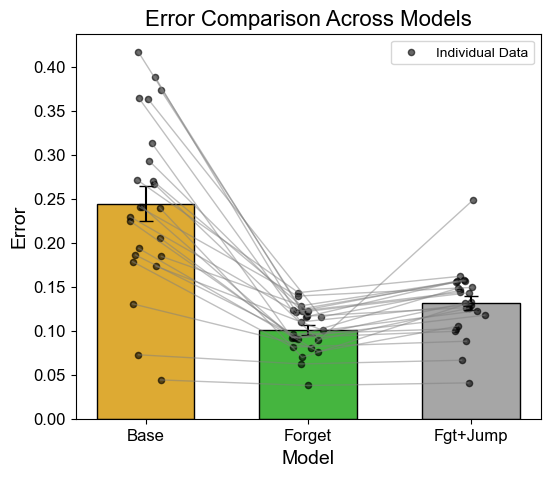

In [108]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_error_comparison(results_1=base_predict_results,
                              results_2=forget_predict_results,
                              results_3=cluster_predict_results,
                              figsize=(6, 5),
                              color_1='#DDAA33',
                              color_2='#45B53F',
                              color_3='#A6A6A6',
                            #   label_1='Base',
                            #   label_2='Fgt',
                              save_path=plots_dir / 'Fig3B_error.png')

#### Fig 3C

In [78]:
import src.nips_plot as nips_plot
importlib.reload(nips_plot)
from src.nips_plot import Fig3

# 初始化处理器
plot_fig3 = Fig3()

In [104]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_acc_comparison(results_1=base_predict_results,
                              results_2=forget_predict_results,
                              subject_id=20,
                              figsize=(8, 5),
                              color_1='#DDAA33',
                              color_2='#45B53F',
                              color_true='#A6A6A6',
                              label_1='Base',
                              label_2='Fgt',
                              save_path=plots_dir / 'Fig3C_base_fgt.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_base_fgt.png


In [103]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_acc_comparison(results_1=base_predict_results,
                              results_2=cluster_predict_results,
                              subject_id=20,
                              figsize=(8, 5),
                              color_1='#DDAA33',
                              color_2='#F39972',
                              color_true='#A6A6A6',
                              label_1='Base',
                              label_2='Fgt+Trans',
                              save_path=plots_dir / 'Fig3C_base_fgt_cluster.png')

Figure saved to /home/yangjiong/CategoryLearning/results/Nips_figures/Fig3C_base_fgt_cluster.png


In [ ]:
plots_dir = Path(project_root) / 'results' / 'Nips_figures'
plot_fig3.plot_acc_comparison(results_1=base_predict_results,
                              results_2=cluster_predict_results,
                              subject_id=20,
                              figsize=(8, 5),
                              color_1='#DDAA33',
                              color_2='#F39972',
                              color_true='#A6A6A6',
                              label_1='Base',
                              label_2='Fgt+Trans',
                              save_path=plots_dir / 'Fig3C_base_fgt_cluster.png')

#### Fig 3D